In [1]:
!python -m pip install paddlepaddle-gpu -i https://pypi.tuna.tsinghua.edu.cn/simple
!pip install "paddleocr>=2.0.1" # Recommend to use version 2.0.1+
!pip install pandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement paddlepaddle-gpu (from versions: none)
ERROR: No matching distribution found for paddlepaddle-gpu


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pdf2image import convert_from_path
import pandas as pd

In [3]:
def show(img, figsize=(12, 9)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

Height: 2338, Width: 1654, Area: 3867052


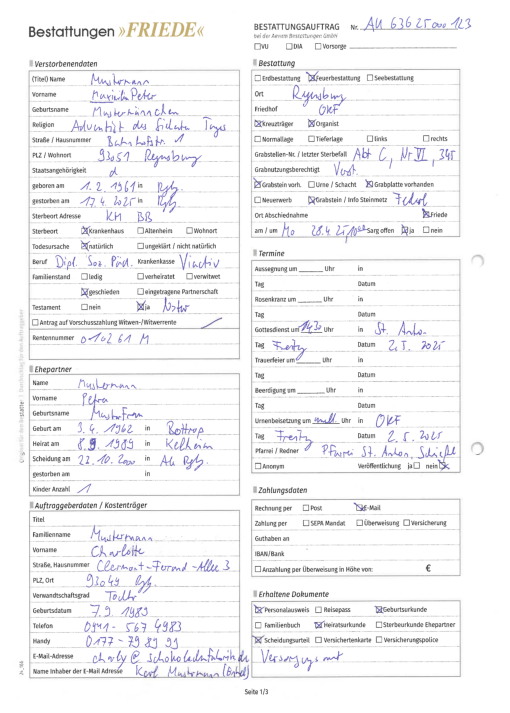

In [4]:
# Load the image
pages = convert_from_path("./testdaten/001.pdf")
page = pages[0]

image = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)

image_height = image.shape[0]
image_width = image.shape[1]
image_area = image_height * image_width

print(f"Height: {image_height}, Width: {image_width}, Area: {image_area}")

show(image)

# Document Scan

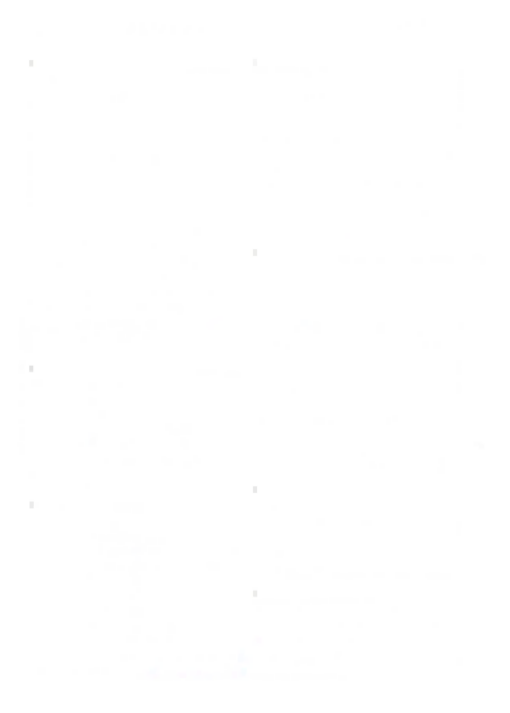

In [5]:
# Repeated Closing operation to remove text from the document.
kernel = np.ones((5,5),np.uint8)
without_text = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=3)

show(without_text)

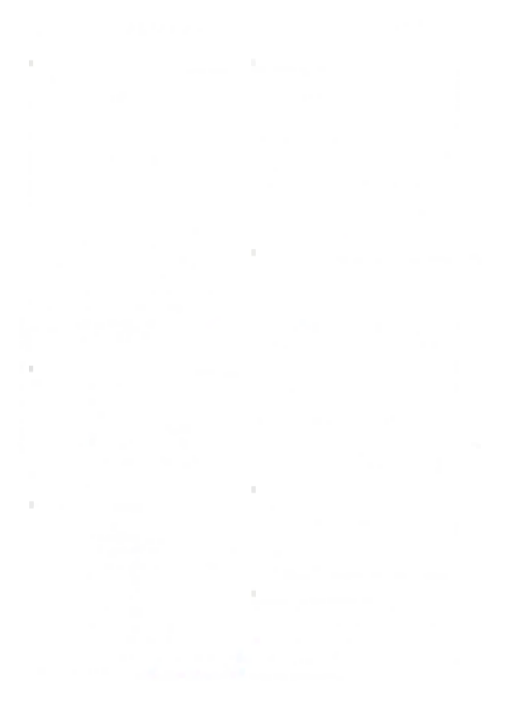

In [6]:
resized = cv2.resize(without_text, (512, 728))
mask = np.zeros(resized.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)


show(resized)

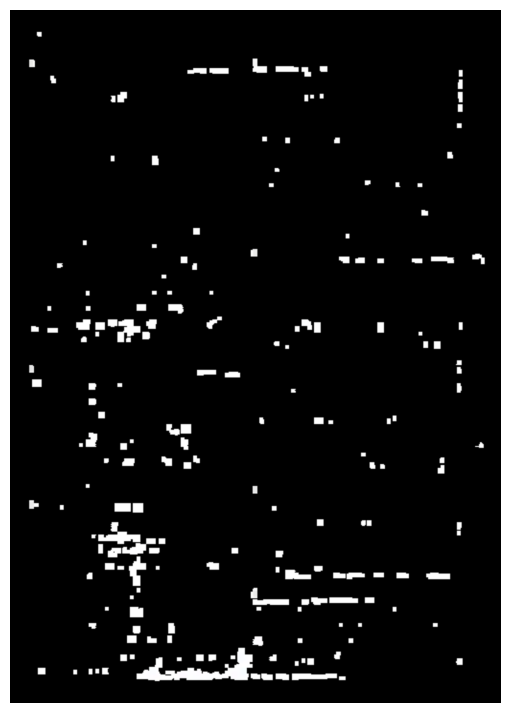

In [7]:
rect = (20,20,resized.shape[1]-20,resized.shape[0]-20)
cv2.grabCut(resized,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
scanned = cv2.resize(resized*mask2[:,:,np.newaxis], (image_width, image_height))
show(scanned)

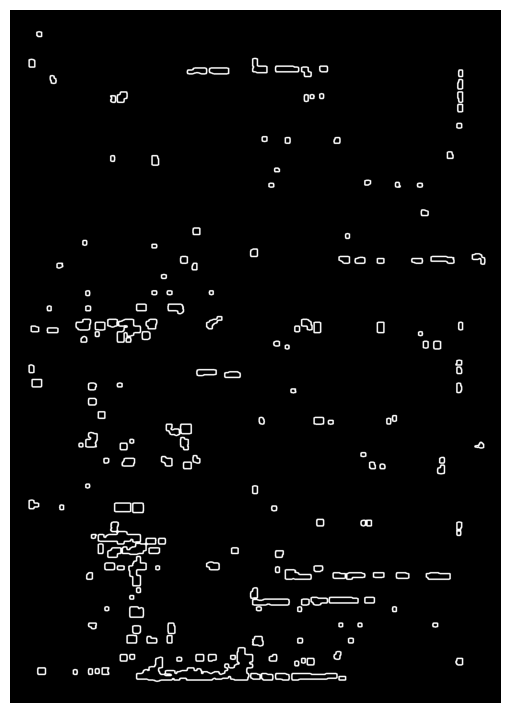

In [8]:
gray = cv2.cvtColor(scanned, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (11, 11), 0)
# Edge Detection.
canny = cv2.Canny(gray, 0, 200)
canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))
show(canny)

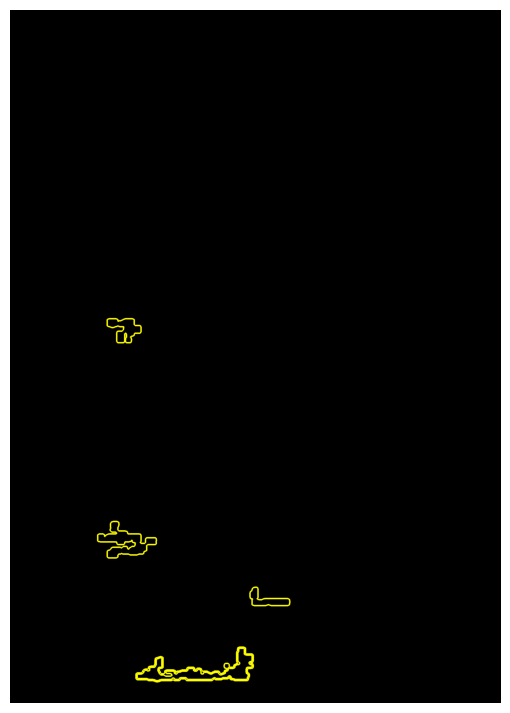

In [9]:
# Blank canvas.
con = np.zeros_like(image)
# Finding contours for the detected edges.
contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
# Keeping only the largest detected contour.
page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
con = cv2.drawContours(con, page, -1, (0, 255, 255), 3)
show(con)

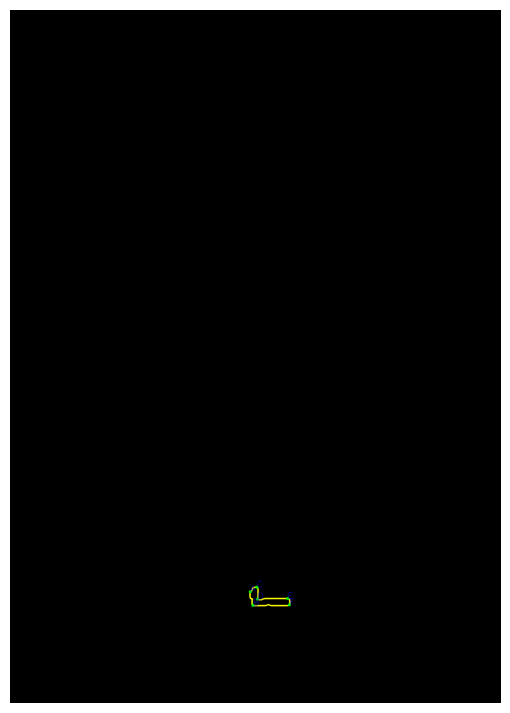

In [10]:
# Blank canvas.
con = np.zeros_like(image)
# Loop over the contours.
for c in page:
    # Approximate the contour.
    epsilon = 0.02 * cv2.arcLength(c, True)
    corners = cv2.approxPolyDP(c, epsilon, True)
    # If our approximated contour has four points
    if len(corners) == 4:
        break
cv2.drawContours(con, c, -1, (0, 255, 255), 3)
cv2.drawContours(con, corners, -1, (0, 255, 0), 10)
# Sorting the corners and converting them to desired shape.
corners = sorted(np.concatenate(corners).tolist())

# Displaying the corners.
for index, c in enumerate(corners):
    character = chr(65 + index)
    cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)

show(con)

In [11]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # Return the ordered coordinates.
    return rect.astype('int').tolist()

Transformed image would be too small. Returning original image.


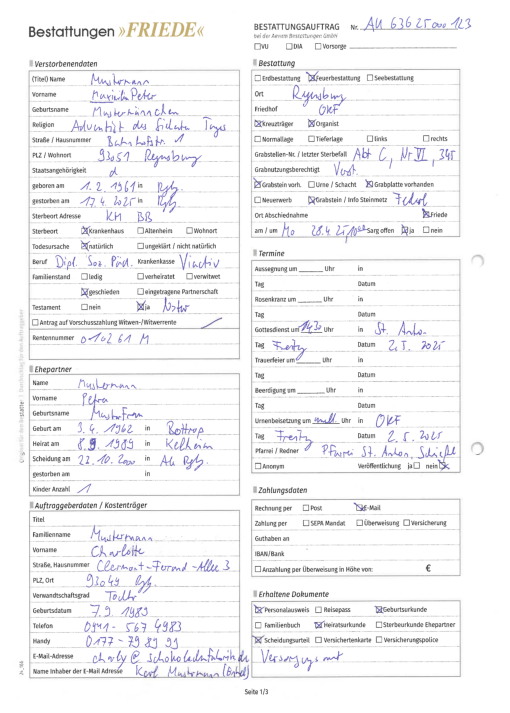

In [12]:
def perspective_transform(image, corners):
    if len(corners) < 4:
        print("Could not find enough corners. Returning original image.")
        return image

    (tl, tr, br, bl) = order_points(corners)
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    destination_corners_contour = np.array(destination_corners).reshape((-1,1,2)).astype(np.int32)
    area = cv2.contourArea(destination_corners_contour)

    if area / image_area < 0.7:
        print("Transformed image would be too small. Returning original image.")
        return image

    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32((tl, tr, br, bl)), np.float32(destination_corners))
    # Perspective transform using homography.
    return cv2.warpPerspective(image, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

image = perspective_transform(image, corners)
show(image)

# Layout Parsing

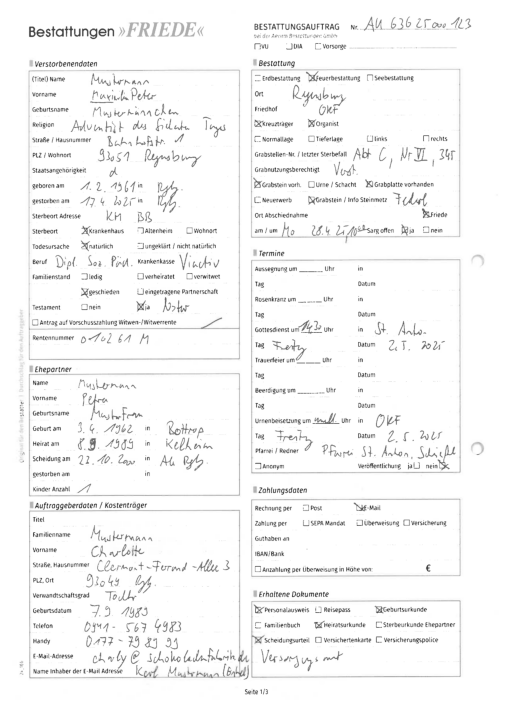

In [13]:
gray = cv2.medianBlur(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 3)
show(gray)

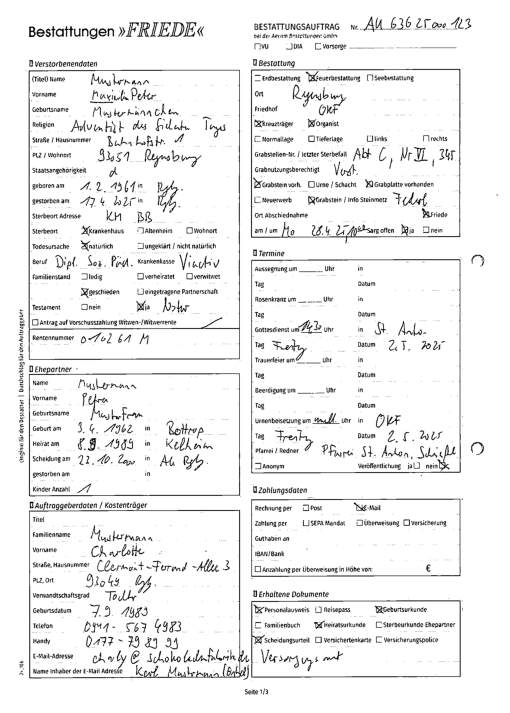

In [14]:
# Thresholding the image
img_bin = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
show(img_bin)

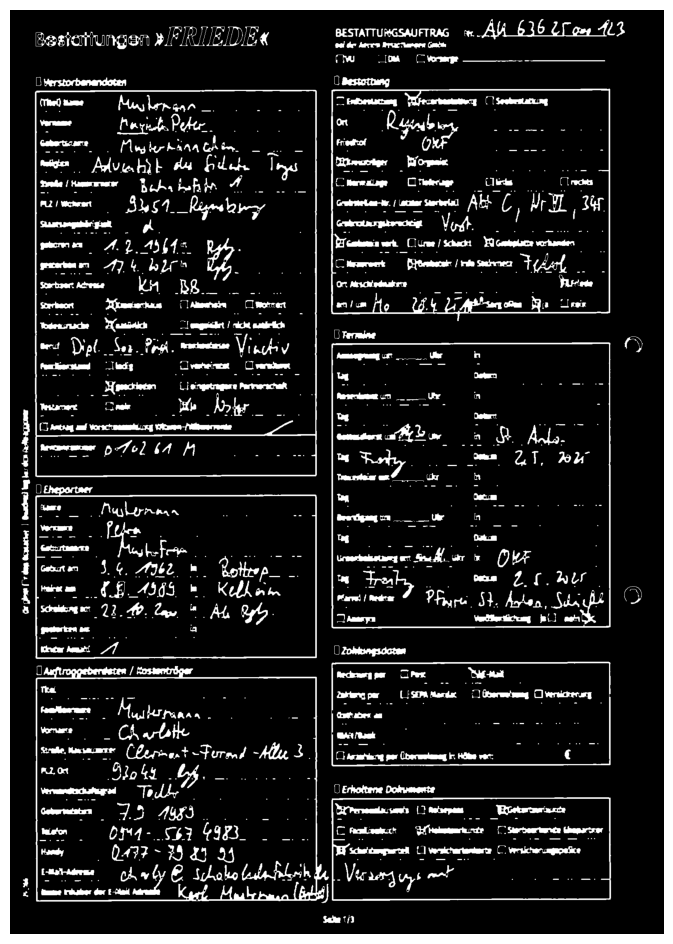

In [15]:
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
# Apply dilation to make edges thicker# Define a kernel
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))

# Dilation and Erosion
edges = cv2.dilate(edges, kernel, iterations=1)
edges = cv2.erode(edges, kernel, iterations=1)

show(edges, figsize=(21, 12))


In [16]:
# TODO: Eventuell corner detection noch ansehen

# Find contours in the binary image
contours, hierarchy = cv2.findContours(~img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw rectangles around each contour
img_groups = image.copy()
target_rois = []

rects = map(cv2.boundingRect, contours)
rects = [(x, y, w, h) for (x, y, w, h) in rects if not (w / image_width < 0.3 or w / image_width > 0.5)]
rects = sorted(rects, key=lambda x: x[0])

rects_left = sorted(rects[:3], key=lambda x: x[1])
rects_right = sorted(rects[3:], key=lambda x: x[1])

data = pd.DataFrame({
    "Verstorbenendaten": rects_left[0],
    "Ehepartner": rects_left[1],
    "Auftraggeberdaten": rects_left[2],
    "Bestattung": rects_right[0],
    "Termine": rects_right[1],
    "Zahlungsdaten": rects_right[2],
    "Erhaltene Dokumente": rects_right[3]
})
data

,Verstorbenendaten,Ehepartner,Auftraggeberdaten,Bestattung,Termine,Zahlungsdaten,Erhaltene Dokumente
0,63,64,64,812,812,813,813
1,202,1207,1686,199,841,1649,1992
2,711,711,742,705,706,705,705
3,978,434,569,589,722,263,260


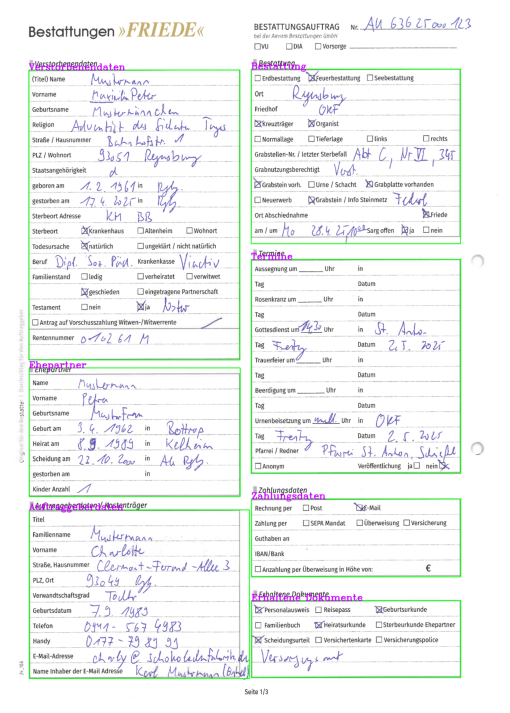

In [17]:
for key, (x, y, w, h) in data.items():
    cv2.rectangle(img_groups, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_groups, key, (x, y), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 0, 200), 2)

show(img_groups)

In [18]:
def cropToSection(section: str):
    x, y, w, h = data[section]
            
    result_img = img_groups.copy()
    cv2.rectangle(result_img, (x, y), (x + w, y + h), (0, 0, 255), 3)

    # Crop and display the Verstorbenendaten section
    cropped_section = result_img[y:y+h, x:x+w]
    plt.figure(figsize=(16, 9))
    plt.imshow(cv2.cvtColor(cropped_section, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f'Cropped {section} section')

    # Save the cropped section to a file
    output_path = f'output/cropped/cropped_{section}_section.jpg'
    cv2.imwrite(output_path, cv2.cvtColor(cropped_section, cv2.COLOR_RGB2BGR))
    print(f"Saved cropped section to {output_path}")
    plt.show()

    return cropped_section

Saved cropped section to output/cropped/cropped_Verstorbenendaten_section.jpg


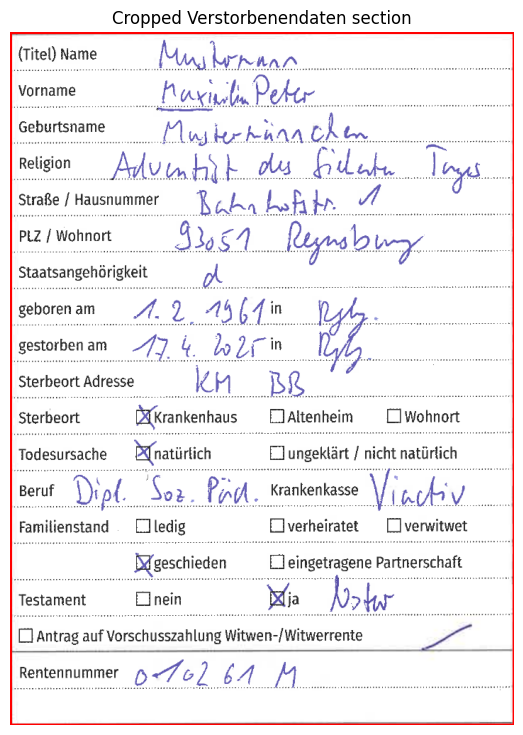

Saved cropped section to output/cropped/cropped_Ehepartner_section.jpg


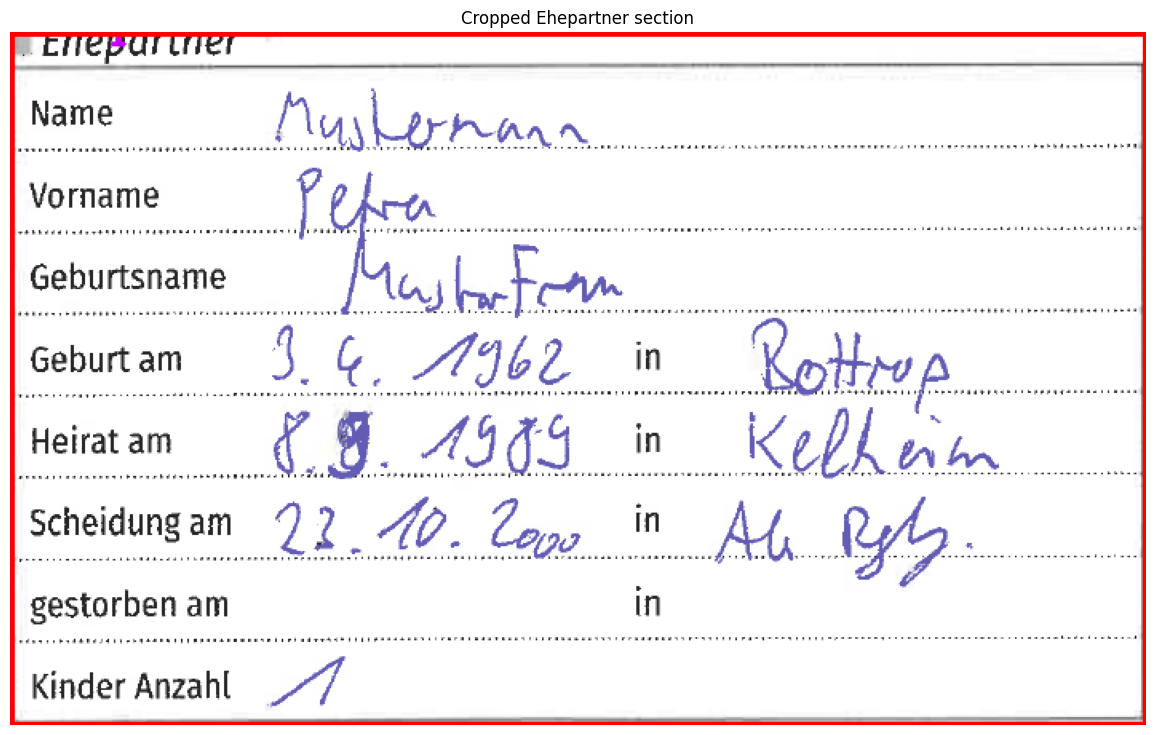

Saved cropped section to output/cropped/cropped_Auftraggeberdaten_section.jpg


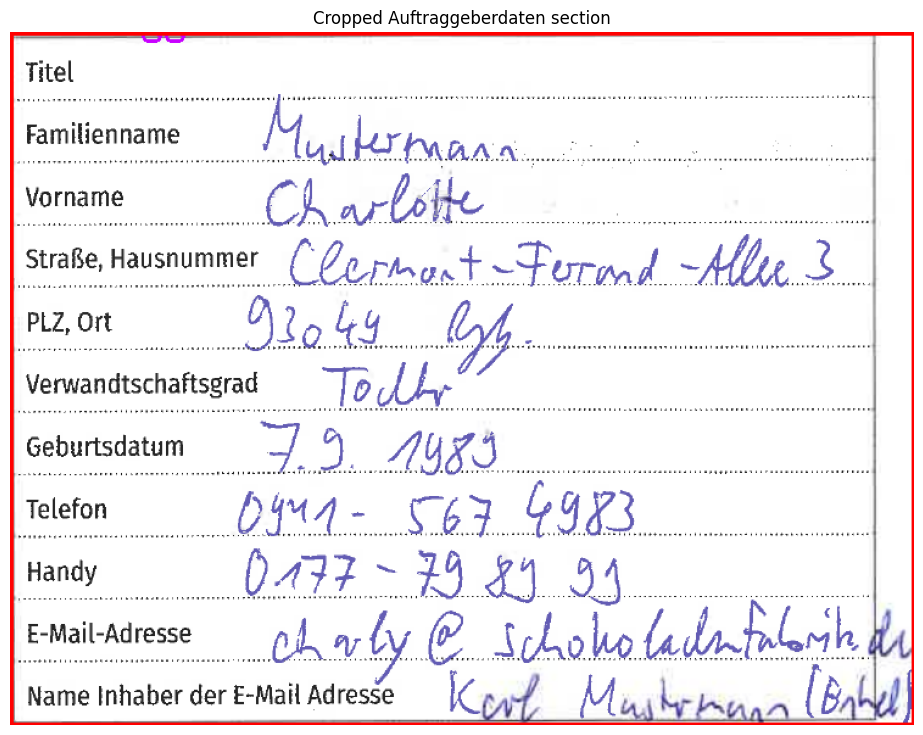

Saved cropped section to output/cropped/cropped_Bestattung_section.jpg


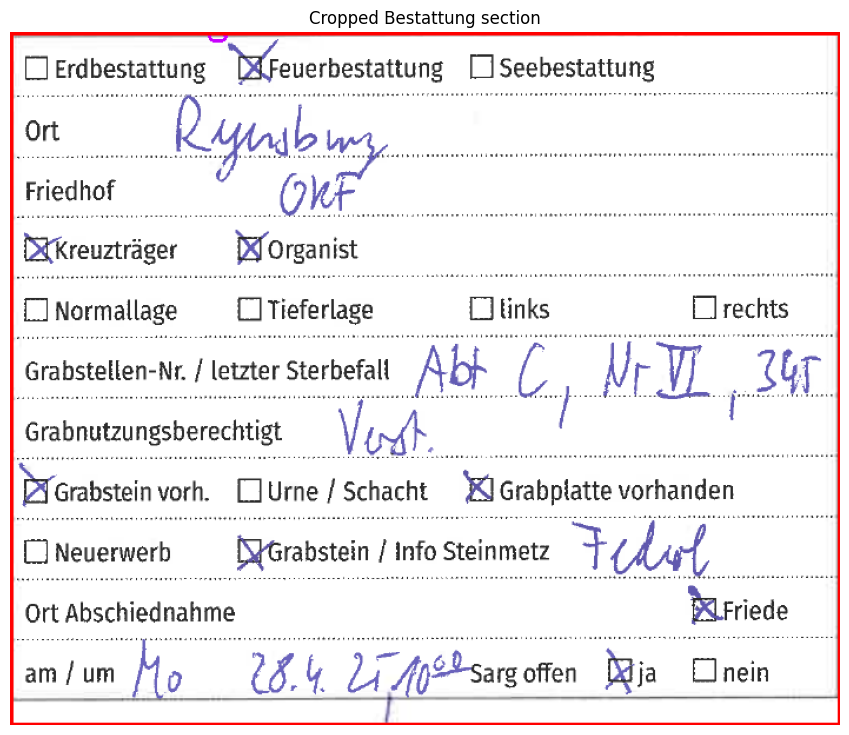

Saved cropped section to output/cropped/cropped_Termine_section.jpg


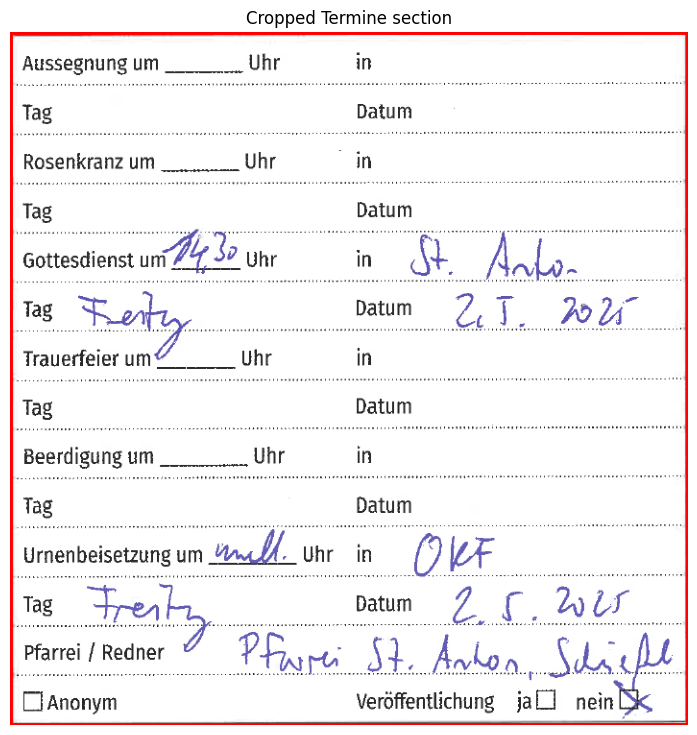

Saved cropped section to output/cropped/cropped_Zahlungsdaten_section.jpg


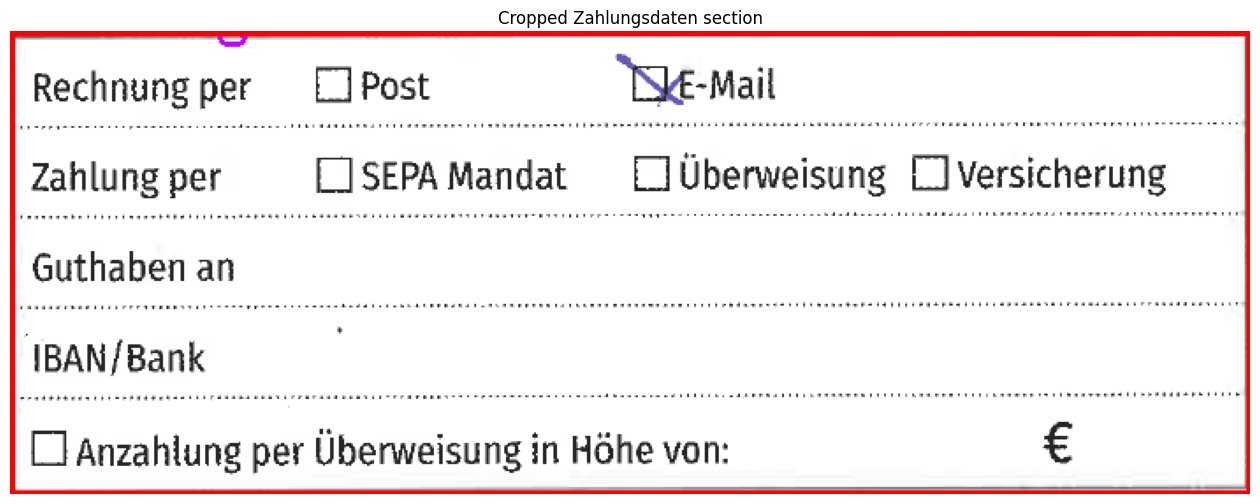

Saved cropped section to output/cropped/cropped_Erhaltene Dokumente_section.jpg


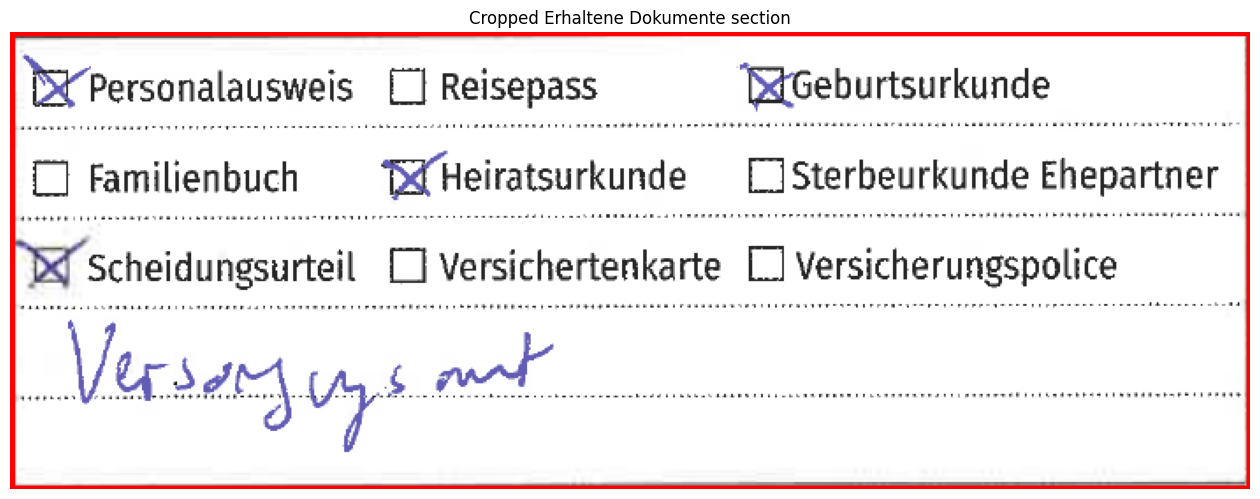

In [19]:
# Croppe Verstorbenendaten section and save it to a file
cropped_sections = []
for i, row in enumerate(data):
    cropped_sections.append((row, cropToSection(row)))

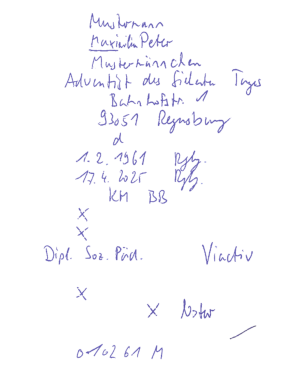

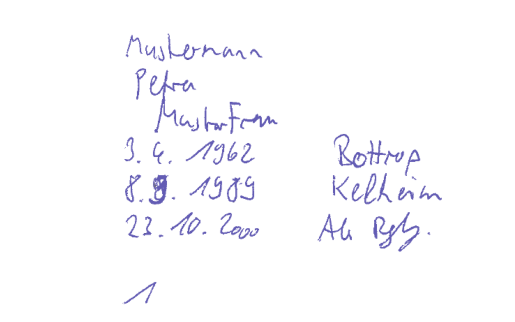

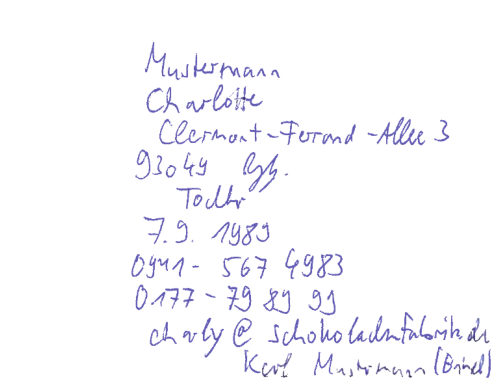

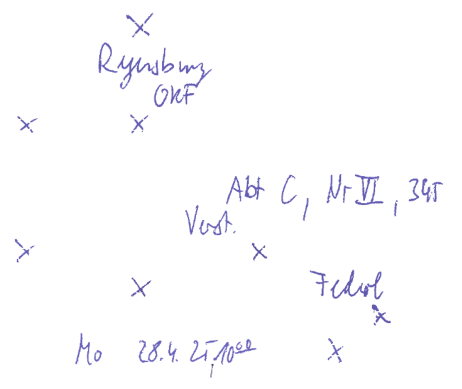

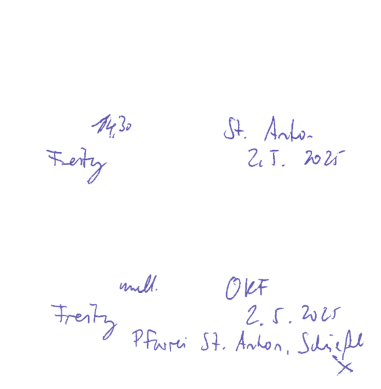

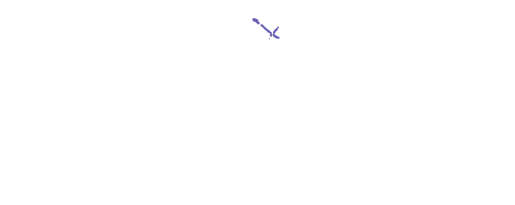

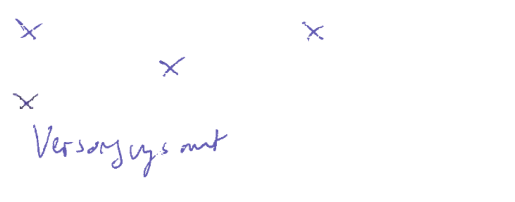

In [20]:
# Remove font that has been identified as black from the image
# blue font should represent the handwritten text

def entferne_schwarze_schrift(image_bgr):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)
    
    # Define range for blue color
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    
    # Create mask for blue pixels
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
    # Create result image with white background
    result = np.full_like(image_bgr, 255)
    
    # Copy only blue pixels to result image
    result = cv2.bitwise_and(image_bgr, image_bgr, mask=blue_mask)
    
    # Set non-blue pixels to white
    result[blue_mask == 0] = [255, 255, 255]
    return result

imgs_handwritten = []

for i, (section, img) in enumerate(cropped_sections):
    img_handwritten = entferne_schwarze_schrift(img)
    imgs_handwritten.append((section, img_handwritten))
    
    plt.imshow(cv2.cvtColor(img_handwritten, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()
    cv2.imwrite(f'output/handwritten/img_handwritten_{section}.jpg', img_handwritten)


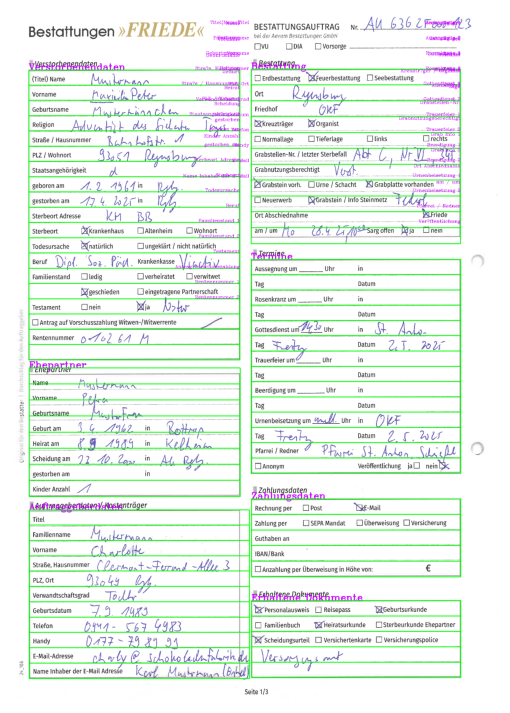

group                field  \
group_index field_index                                             
0           0              Verstorbenendaten          Titel(Name)   
            1              Verstorbenendaten              Vorname   
            2              Verstorbenendaten          Geburtsname   
            3              Verstorbenendaten             Religion   
            4              Verstorbenendaten  Straße / Hausnummer   
...                                      ...                  ...   
6           0            Erhaltene Dokumente              Zeile 1   
            1            Erhaltene Dokumente              Zeile 2   
            2            Erhaltene Dokumente              Zeile 3   
            3            Erhaltene Dokumente              Zeile 4   
            4            Erhaltene Dokumente              Zeile 5   

                                     bounding_rect  
group_index field_index                             
0           0                 [[63, 0], [774, 51]]  
            1               [[63, 51], [774, 102]]  
            2              [[63, 102], [774, 154]]  
            3              [[63, 154], [774, 205]]  
            4              [[63, 205], [774, 257]]  
...                                            ...  
6           0               [[813, 0], [1518, 52]]  
            1             [[813, 52], [1518, 104]]  
            2            [[813, 104], [1518, 156]]  
            3            [[813, 156], [1518, 208]]  
            4            [[813, 208], [1518, 260]]  

[73 rows x 3 columns]

In [21]:
groups = pd.read_csv('groups.csv', index_col=["group_index", "field_index"])
img_fields = img_groups.copy()

def get_points(row):
    group_name = row["group"]
    field_index = row.name[1]
    (x, y, w, h) = data[group_name]

    parts = len(groups[groups.group == group_name])
    part_size = h / parts
    part_start_y = part_size * field_index

    # Returns top-left and bottom-right coordinates of a rectangle:
    # point1: (x, y + part_start_y) - top left corner
    # point2: (x + width, y + part_start_y + part_size) - bottom right corner
    return [
        np.array([x, part_start_y]).astype(np.int32),
        np.array([x + w, part_start_y + part_size]).astype(np.int32)
    ]

groups["bounding_rect"] = groups.apply(get_points, axis=1)

for _, row in groups.iterrows():
    field_name = row["field"]
    group_name = row["group"]
    (x, y, w, h) = data[group_name]

    [point1, point2] = row["bounding_rect"]
    point1_copy = point1.copy()
    point2_copy = point2.copy()
    point1_copy[1] += y
    point2_copy[1] += y

    cv2.rectangle(
        img_fields,
        point1_copy,
        point2_copy,
        (0, 255, 0),
        2)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_size = 0.5
    font_thickness = 1
    ([text_width, _], text_height) = cv2.getTextSize(field_name, font, font_size, font_thickness)
    cv2.putText(img_fields, field_name, np.array([point2[0] - text_width, point2[1] - text_height]).astype(np.int32), font, font_size, (255, 0, 200), font_thickness)

show(img_fields)

cv2.imwrite("img_fields.jpg", img_fields)
groups

In [40]:
from src.utils import detect_boxes

hw_coordinates = {}
hw_centers = {}

# detect handwritten text with PaddleOCR
for i, (section, img) in enumerate(imgs_handwritten):
    img_path = f"output/handwritten/img_handwritten_{section}.jpg"
    print(f"Detect handwriting in section {section}...")
    handwritten_boxes = detect_boxes(img_path, f"detected_hw_boxes_{section}")

    hw_coordinates[section] = handwritten_boxes[0]
    hw_centers[section] = handwritten_boxes[4]

Detect handwriting in section Verstorbenendaten...
[2025/06/08 13:44:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/mdo/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/mdo/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inve

In [94]:
# assign handwritten boxes to label rows

def assign_boxes_to_rows(hw_center, hw_coords, label_rows):
    assignments = []

    # Calculate center points for each handwritten box
    for j, (x, y) in enumerate(hw_center):
        # Check which row contains this center point
        for i, row in enumerate(label_rows):
            left_top_pt = row[0]
            bottom_right_pt = row[1]

            if left_top_pt[1] <= y <= bottom_right_pt[1]:
                assignments.append((i, hw_coords[j]))
                
    return assignments

label_hw_assigments = {}

# Create a dictionary mapping group indices to group names
group_map = {idx: name for idx, name in enumerate(groups["group"].unique())}

for idx, name in group_map.items():
    hw_group_center = hw_centers[name]
    hw_group_coords = hw_coordinates[name]

    group_label_boxes = groups["bounding_rect"][idx]
    label_hw_assigments[name] = assign_boxes_to_rows(hw_group_center, hw_group_coords, group_label_boxes)

print(label_hw_assigments)




{'Verstorbenendaten': [(0, [(209, 11), (407, 20), (405, 60), (208, 50)]), (1, [(209, 65), (428, 58), (430, 102), (210, 109)]), (2, [(212, 123), (504, 112), (505, 153), (213, 164)]), (3, [(145, 167), (575, 161), (576, 207), (146, 213)]), (3, [(587, 158), (667, 182), (654, 224), (574, 200)]), (4, [(261, 221), (526, 209), (528, 254), (263, 265)]), (5, [(233, 263), (345, 267), (343, 313), (232, 309)]), (5, [(393, 271), (482, 277), (480, 314), (391, 309)]), (6, [(271, 327), (301, 327), (301, 361), (271, 361)]), (7, [(175, 372), (363, 372), (363, 414), (175, 414)]), (8, [(177, 426), (359, 426), (359, 461), (177, 461)]), (9, [(255, 469), (322, 469), (322, 512), (255, 512)]), (9, [(360, 475), (418, 475), (418, 517), (360, 517)]), (10, [(181, 528), (206, 528), (206, 559), (181, 559)]), (11, [(178, 577), (204, 577), (204, 606), (178, 606)]), (12, [(506, 616), (647, 621), (645, 680), (503, 675)]), (12, [(92, 626), (351, 626), (351, 671), (92, 671)]), (14, [(184, 745), (195, 745), (195, 755), (184

In [95]:
# save assignments to groups dataframe

def get_hw_points(row):
    field_index = row.name[1]
    group_name = row["group"]

    hw_rects = []

    section_assignments = label_hw_assigments[group_name]

    for item in section_assignments:
        if item[0] == field_index:
            print (f"Found {item} for {field_index}")
            hw_rects.append(item[1])

    return hw_rects

groups["hw_bounding_rect"] = groups.apply(get_hw_points, axis=1)

Found (0, [(209, 11), (407, 20), (405, 60), (208, 50)]) for 0
Found (1, [(209, 65), (428, 58), (430, 102), (210, 109)]) for 1
Found (2, [(212, 123), (504, 112), (505, 153), (213, 164)]) for 2
Found (3, [(145, 167), (575, 161), (576, 207), (146, 213)]) for 3
Found (3, [(587, 158), (667, 182), (654, 224), (574, 200)]) for 3
Found (4, [(261, 221), (526, 209), (528, 254), (263, 265)]) for 4
Found (5, [(233, 263), (345, 267), (343, 313), (232, 309)]) for 5
Found (5, [(393, 271), (482, 277), (480, 314), (391, 309)]) for 5
Found (6, [(271, 327), (301, 327), (301, 361), (271, 361)]) for 6
Found (7, [(175, 372), (363, 372), (363, 414), (175, 414)]) for 7
Found (8, [(177, 426), (359, 426), (359, 461), (177, 461)]) for 8
Found (9, [(255, 469), (322, 469), (322, 512), (255, 512)]) for 9
Found (9, [(360, 475), (418, 475), (418, 517), (360, 517)]) for 9
Found (10, [(181, 528), (206, 528), (206, 559), (181, 559)]) for 10
Found (11, [(178, 577), (204, 577), (204, 606), (178, 606)]) for 11
Found (12, [

In [96]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
groups


group                    field  \
group_index field_index                                                 
0           0              Verstorbenendaten              Titel(Name)   
            1              Verstorbenendaten                  Vorname   
            2              Verstorbenendaten              Geburtsname   
            3              Verstorbenendaten                 Religion   
            4              Verstorbenendaten      Straße / Hausnummer   
            5              Verstorbenendaten            PLZ / Wohnort   
            6              Verstorbenendaten      Staatsangehörigkeit   
            7              Verstorbenendaten               geboren am   
            8              Verstorbenendaten             gestorben am   
            9              Verstorbenendaten        Sterbeort Adresse   
            10             Verstorbenendaten                Sterbeort   
            11             Verstorbenendaten             Todesursache   
            12             Verstorbenendaten                    Beruf   
            13             Verstorbenendaten          Familienstand 1   
            14             Verstorbenendaten          Familienstand 2   
            15             Verstorbenendaten                Testament   
            16             Verstorbenendaten  Antrag Vorschusszahlung   
            17             Verstorbenendaten           Rentennummer 1   
            18             Verstorbenendaten           Rentennummer 2   
1           0                     Ehepartner                     Name   
            1                     Ehepartner                  Vorname   
            2                     Ehepartner              Geburtsname   
            3                     Ehepartner                   Geburt   
            4                     Ehepartner                   Heirat   
            5                     Ehepartner                Scheidung   
            6                     Ehepartner                gestorben   
            7                     Ehepartner            Kinder Anzahl   
2           0              Auftraggeberdaten                    Titel   
            1              Auftraggeberdaten             Familienname   
            2              Auftraggeberdaten                  Vorname   
            3              Auftraggeberdaten       Straße, Hausnummer   
            4              Auftraggeberdaten                 PLZ, Ort   
            5              Auftraggeberdaten      Verwandtschaftsgrad   
            6              Auftraggeberdaten             Geburtsdatum   
            7              Auftraggeberdaten                  Telefon   
            8              Auftraggeberdaten                    Handy   
            9              Auftraggeberdaten                   E-Mail   
            10             Auftraggeberdaten  Name Inhaber der E-Mail   
3           0                     Bestattung                      Art   
            1                     Bestattung                      Ort   
            2                     Bestattung                 Friedhof   
            3                     Bestattung   Kreuzträger / Organist   
            4                     Bestattung                     Lage   
            5                     Bestattung          Grabstellen-Nr.   
            6                     Bestattung   Grabnutzungsberechtigt   
            7                     Bestattung              Grab Info 1   
            8                     Bestattung              Grab Info 2   
            9                     Bestattung         Ort Abschiedname   
            10                    Bestattung                  am / um   
4           0                        Termine             Aussegnung 1   
            1                        Termine             Aussegnung 2   
            2                        Termine             Rosenkranz 1   
            3                        Termine             Rosenkranz 2   
            4           